In [19]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from lob import LOB
from maslov import maslov
from order import display_order_menu

# Limit order book

<IPython.core.display.Javascript object>


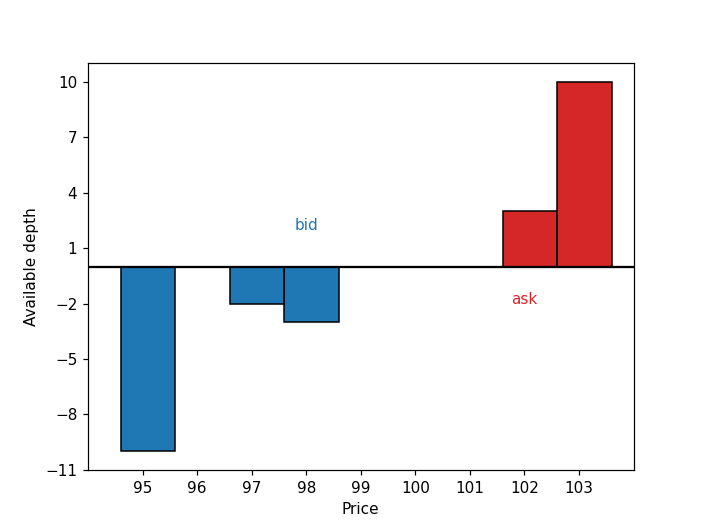

In [20]:
lob = LOB()

t = 0
while True:
    order = display_order_menu()
    if order is None:
        break
    
    order.time = t
    lob.place(order)
        
    lob.render(show_price=False)
    t += 1

# Maslov model

In [37]:
params = {
    'price0': 100,
    'T': 1000,
    'p_limit': 0.5,
    'p_sell': 0.6,
    'max_quantity': 1,
    'max_delta_price': 1,
}

<IPython.core.display.Javascript object>


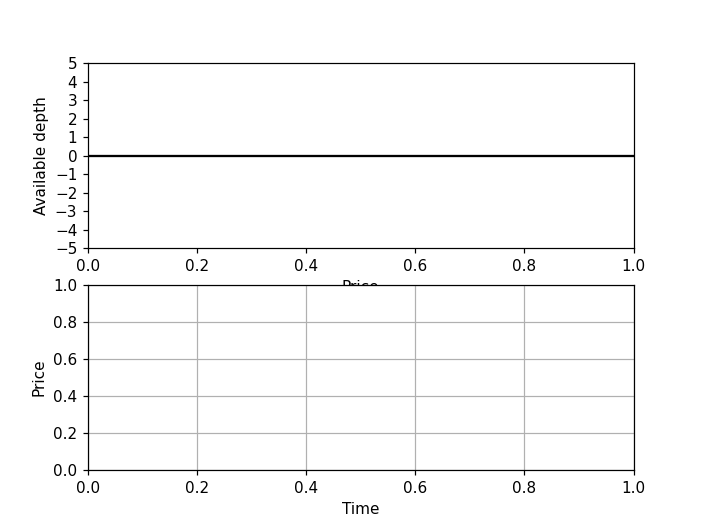

In [33]:
_ = maslov(interactive=True, **params)

<IPython.core.display.Javascript object>


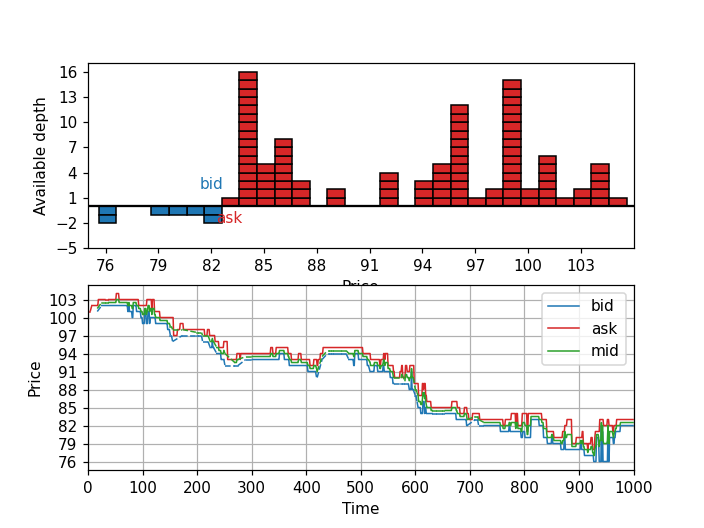

In [38]:
lob = maslov(**params)
lob.render()

<IPython.core.display.Javascript object>


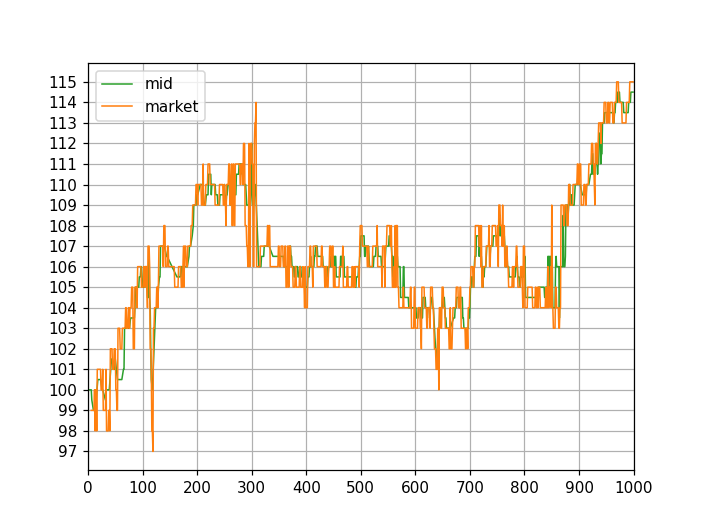

In [24]:
def get_finite(data):
    idx = np.where(np.isfinite(data))[0]
    return idx, np.array(data)[idx]


fig = plt.figure()
ax = plt.gca()
ax.grid('on')
T = params['T']
ax.set(xlim=(0, T), xticks=np.arange(0, T + 1, T // 10), yticks=np.arange(lob.xmin, lob.xmax + 1))

ax.plot(*get_finite(lob.data['mid']))[0].set(label='mid', linewidth=1, color='tab:green')
ax.plot(*get_finite(lob.data['market']))[0].set(label='market', linewidth=1, color='tab:orange')

ax.legend()
plt.show()

# Stylized fact on return time series

- Stationarity
- Heavy tail distribution
- Negative ACF(1) (mean-reversion)

In [25]:
idx_mkt, mkt = get_finite(lob.data['market'])

In [26]:
ret = (mkt[1:] - mkt[:-1]) / mkt[:-1]

<IPython.core.display.Javascript object>


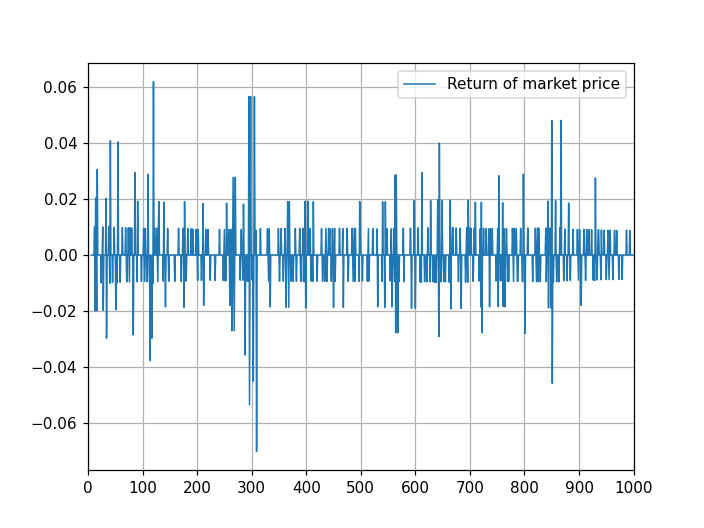

In [27]:
fig = plt.figure()
ax = plt.gca()
ax.grid('on')
ax.set(xlim=(0, T), xticks=np.arange(0, T + 1, T // 10))

ax.plot(idx_mkt[1:], ret)[0].set(label='Return of market price', linewidth=1)

ax.legend()
plt.show()

<IPython.core.display.Javascript object>


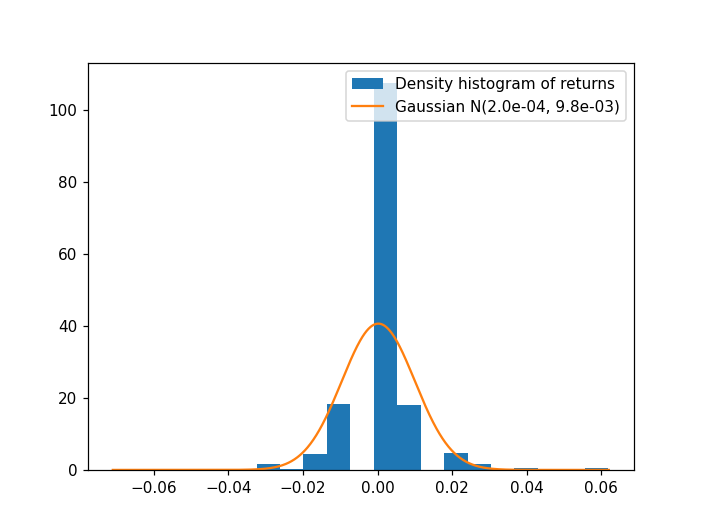

In [28]:
mu, sig = ret.mean(), ret.std()
bounds = np.floor(ret.min() * 1e3) / 1e3, np.ceil(ret.max() * 1e3) / 1e3
x_axis = np.linspace(*bounds, 1000)

fig = plt.figure()
ax = plt.gca()
density, bins, _ = ax.hist(ret, bins=21, density=True, label='Density histogram of returns')
ax.plot(x_axis, norm.pdf(x_axis, mu, sig), label=f'Gaussian N({mu:.1e}, {sig:.1e})')
ax.legend()
plt.show()

In [29]:
count = np.round(density * np.diff(bins) * len(ret)).astype(int)
for i in range(len(bins) - 1):
    l, u = bins[i], bins[i + 1]
    p = norm.cdf(u, mu, sig) - norm.cdf(l, mu, sig)
    print(f"In [{l:+.2f}, {u:+.2f}], density = {density[i]:.2e} (count = {count[i]:4d}), proba under gaussian = {p:.2e}")

In [-0.07, -0.06], density = 1.60e-01 (count =    1), proba under gaussian = 3.19e-11
In [-0.06, -0.06], density = 0.00e+00 (count =    0), proba under gaussian = 1.88e-09
In [-0.06, -0.05], density = 1.60e-01 (count =    1), proba under gaussian = 7.37e-08
In [-0.05, -0.05], density = 3.20e-01 (count =    2), proba under gaussian = 1.94e-06
In [-0.05, -0.04], density = 0.00e+00 (count =    0), proba under gaussian = 3.40e-05
In [-0.04, -0.03], density = 3.20e-01 (count =    2), proba under gaussian = 4.01e-04
In [-0.03, -0.03], density = 1.60e+00 (count =   10), proba under gaussian = 3.16e-03
In [-0.03, -0.02], density = 3.20e-01 (count =    2), proba under gaussian = 1.68e-02
In [-0.02, -0.01], density = 4.32e+00 (count =   27), proba under gaussian = 5.96e-02
In [-0.01, -0.01], density = 1.83e+01 (count =  114), proba under gaussian = 1.42e-01
In [-0.01, -0.00], density = 0.00e+00 (count =    0), proba under gaussian = 2.29e-01
In [-0.00, +0.01], density = 1.08e+02 (count =  672), 

<IPython.core.display.Javascript object>


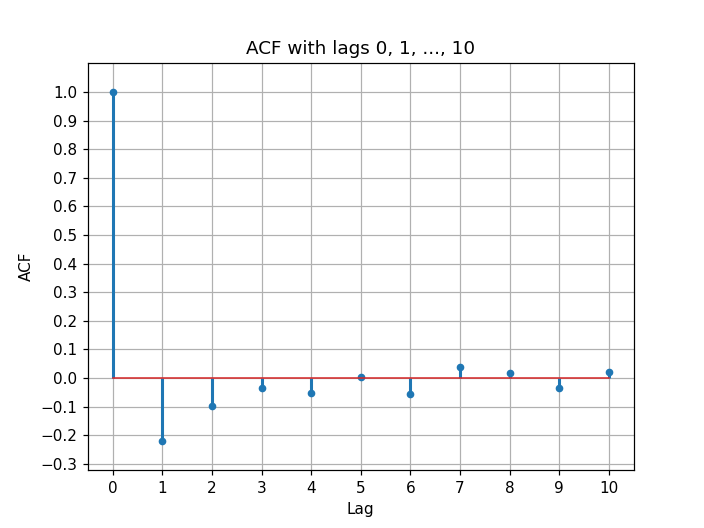

In [30]:
def acf(x, lag):
    assert x.ndim == 1
    mu, sig = x.mean(), x.std()
    x_ = x[:-lag] if lag > 0 else x
    x_shifted = x[lag:]
    return np.mean((x_ - mu) * (x_shifted - mu)) / sig ** 2


nlags = 10 # \rho_0, \rho_1, ..., \rho_{nlags}
acfs = [acf(ret, lag) for lag in range(nlags + 1)]

fig = plt.figure()
ax = plt.gca()
ax.grid('on')
ax.set(xlabel='Lag', ylabel='ACF', title=f'ACF with lags 0, 1, ..., {nlags}',
       xticks=np.arange(0, nlags + 1, 1), yticks=np.arange(-1.1, 1.1, 0.1),
       ylim=(min(acfs) - 0.1, max(acfs) + 0.1))
markerline, stemlines, baseline = ax.stem(acfs)
markerline.set(color='tab:blue', marker='o', markersize=4)
stemlines.set(color='tab:blue', linewidth=2)
baseline.set(color='tab:red', linewidth=1)

plt.show()

In [31]:
import scipy
scipy.stats.kstest(ret, 'norm', args=(mu, sig))

KstestResult(statistic=0.34494542827510327, pvalue=4.928190234050166e-106)